# Exercice on local approximation of an bivariate quadratic expression using linear regression

Idea : 
- Given two features, extract y (the label)
- Perform linear regression analiticaly
- Perform linear regression with gradient descent (SGD)

In [1]:
#%matplotlib notebook
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
import scipy as sy
import pandas
# Axes3D necessary for surface plot
from mpl_toolkits.mplot3d import Axes3D

In 2D, it would require many points to uniformly cover the x plan

It is then prefer to draw x points from a 2D uniform distribution

Drawing y as function of $x_0, x_1$ is then more challenging as $x_0$ and $x_1$ are not continuous monotonic vectors

$f(x) = (x_0−0.2)^4 + (x_0−0.1)^3 + 0.1 x_1^2 + 0.35 = x_0^4 + 0.2 x_0^3 − 0.06 x_0^2 − 0.002 x_0 + 0.1 x_1^2 + 0.3506$

In [2]:
#
xMin = np.array([0, -0.5])
xMax = np.array([0.5, 0.5])
# f(x) as a bivariate polynom
fPoly = np.array([[-0.002, 0], [-0.06, 0.1], [0.2, 0], [1, 0]])
#
b = 0.35
std = 0.01
#
def generateBatch(N):
    x = random.uniform(xMin, xMax, (N, 2))
    yClean = (x[:,0]-0.2)**4 + (x[:,0]-0.1)**3 + 0.1*x[:,1]**2 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

In [3]:
N = 100000
xTrain, yTrain, yTrainClean = generateBatch(N);

print('x', xTrain.shape, ', yClean', yTrainClean.shape, ', y', yTrain.shape);
xTest, yTest, yTestClean = generateBatch(N);

x (100000, 2) , yClean (100000,) , y (100000,)


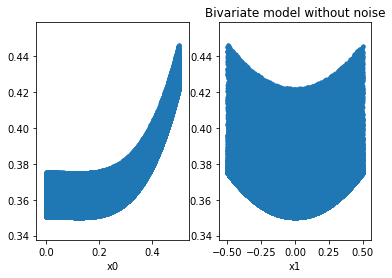

In [4]:
plt.subplot(1,2,1)
plt.scatter(xTrain[:,0], yTrainClean, marker='.');
plt.xlabel('x0')
plt.subplot(1,2,2)
plt.scatter(xTrain[:,1], yTrainClean, marker='.');
plt.xlabel('x1')
plt.title('Bivariate model without noise');

It looks like a tobogan from the side (x0) and from the front (x1)

## Analiticaly / Closed form

Remove biases

In [5]:
xUnB = xTrain - np.mean(xTrain, axis=0)
yUnB = yTrain - np.mean(yTrain)

## Maison

In [6]:
xTxInv = np.linalg.inv(np.matmul(xUnB.T,xUnB))
w = np.matmul(xTxInv,np.matmul(xUnB.T, yUnB))
w

array([0.11246515, 0.00015961])

In [7]:
bEst = np.mean(yTrain - np.matmul(xTrain, w))
bEst

0.3440391817612881

In [8]:
yEst1 = np.matmul(xTest, w) + bEst

mse1 = 0.00025595974467259414


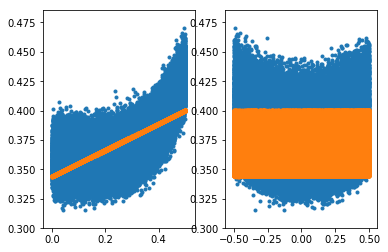

In [9]:
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst1, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst1, marker='.');
# Mean square error 'a la mano'
mse1 = np.dot(yTest-yEst1, yTest-yEst1) / N
print('mse1 =', mse1);

The tobogan has been approximated by a plan

## Home made with powers
Adding some flexibility to the model using powers of x

In [10]:
xTrain2 = np.concatenate((xTrain, xTrain**2, xTrain**3, xTrain**4), axis=1)
xTrain2.shape

(100000, 8)

In [11]:
x2UnB = xTrain2 - np.mean(xTrain2, axis=0)

In [12]:
x2Tx2Inv = np.linalg.inv(np.matmul(x2UnB.T,x2UnB))
w2 = np.matmul(x2Tx2Inv,np.matmul(x2UnB.T, yUnB))
w2

array([-7.90345677e-03,  9.29562130e-05, -1.87718743e-02,  1.00588112e-01,
        1.01484803e-01,  1.00852423e-03,  1.07541307e+00, -3.42089605e-03])

In [13]:
xTest2 = np.concatenate((xTest, xTest**2, xTest**3, xTest**4), axis=1)
yEst2 = np.matmul(xTest2, w2) + bEst

mse2 = 0.0001451877021119685 , mse2Clean = 4.5313689933520916e-05


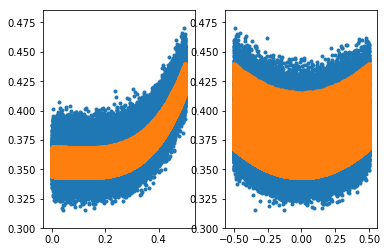

In [14]:
plt.subplot(1,2,1)
plt.scatter(xTest2[:,0], yTest, marker='.');
plt.scatter(xTest2[:,0], yEst2, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest2[:,1], yTest, marker='.');
plt.scatter(xTest2[:,1], yEst2, marker='.');
mse2 = np.dot(yTest-yEst2, yTest-yEst2) / N
mse2Clean = np.dot(yTestClean-yEst2, yTestClean-yEst2) / N
print('mse2 =', mse2, ', mse2Clean =', mse2Clean);

The polynomial of y has been well approximated.

The MSE on the noisy sample cannot be lower than the MSE of the noise which is $(10^{-2})^2=10^{-4}$

## NumPy least square

In [15]:
fit4, residues, rank, s = np.linalg.lstsq(xUnB, yUnB)
fit4

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([0.11246515, 0.00015961])

In [16]:
yEst4 = np.matmul( xTest, fit4) + bEst

mse4 = 0.00025595974467259414


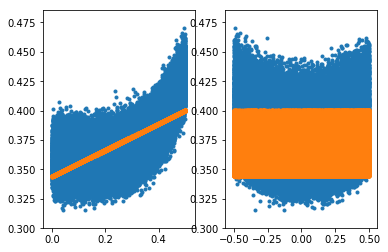

In [17]:
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTest, marker='.');
plt.scatter(xTest[:,0], yEst4, marker='.');
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTest, marker='.');
plt.scatter(xTest[:,1], yEst4, marker='.');
mse4 = metrics.mean_squared_error(yTest, yEst4)
print('mse4 =', mse4);

# Gradient descent

Attempt to find a value of w such that the gradient is null (indication of minima, or saddle point)

Loop on the training data until the gradient is below a threshold

In [18]:
w6 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.0001 # Quick
gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
gradientNorm = np.sum(gradient**2) # bivariate
print('w start =', w6, ', Gradient norm =', gradientNorm)
w6Learn = [np.concatenate((w6, [gradientNorm]))]
while gradientNorm > threshold:
    w6 = w6 - learningRate * gradient
    gradient = np.matmul(xUnB.T, np.matmul(xUnB,w6) - yUnB)
    gradientNorm = np.sum(gradient**2) # bivariate
    # print('w =', w6, ', Gradient norm =', gradientNorm)
    w6Learn.append(np.concatenate((w6, [gradientNorm])))
print('w end =', w6, ', Gradient norm =', gradientNorm, ', num iteration =', len(w6Learn))
df6 = pandas.DataFrame(w6Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 1852507175.743853
w end = [0.11246554 0.00015961] , Gradient norm = 6.602427993929725e-07 , num iteration = 71


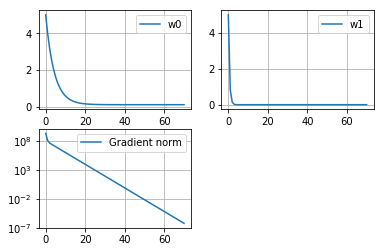

In [19]:
plt.subplot(2,2,1)
plt.plot(df6['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df6['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df6['Gradient norm'])
plt.grid()
plt.legend();

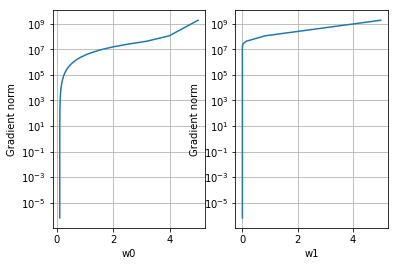

In [20]:
plt.subplot(1,2,1)
plt.semilogy(df6['w0'], df6['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.subplot(1,2,2)
plt.semilogy(df6['w1'], df6['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [21]:
yEst6 = np.matmul(xTest, w6) + bEst

mse6 = 0.00025595971184029905


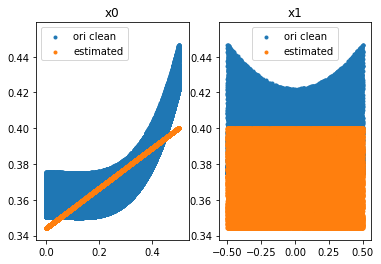

In [22]:
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst6, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst6, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse6 = metrics.mean_squared_error(yTest, yEst6)
print('mse6 =', mse6);

## Stochastic gradient descent

Loop on new data

In [23]:
def calcGradient(x, y, w):
    _x = x - np.mean(x, axis=0)
    _y = y - np.mean(y)
    gradient = np.matmul(_x.T, np.matmul(_x, w) - _y)
    return gradient

In [24]:
Nbatch = 1000
w7 = np.array([5, 5])
threshold = 1e-6
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
gradient = calcGradient(xBatch, yBatch, w7)
gradientNorm = np.sum(gradient**2) 
print('w start =', w7, ', Gradient norm =', gradientNorm)
w7Learn = [np.concatenate((w7, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w7 = w7 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    gradient = calcGradient(xBatch, yBatch, w7)
    gradientNorm = np.sum(gradient**2)
    w7Learn.append(np.concatenate((w7, [gradientNorm])))
    learningRate = learningRate * 0.99
print('w end =', w7, ', Gradient norm =', gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('w0', 'w1', 'Gradient norm'))

w start = [5 5] , Gradient norm = 176692.17212074524
w end = [1.12803168e-01 7.80496053e-05] , Gradient norm = 6.58944709993439e-07 , num iteration = 4881


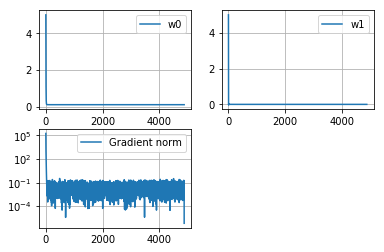

In [25]:
plt.subplot(2,2,1)
plt.plot(df7['w0'])
plt.grid()
plt.legend();
plt.subplot(2,2,2)
plt.plot(df7['w1'])
plt.grid()
plt.legend();
plt.subplot(2,2,3)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.legend();

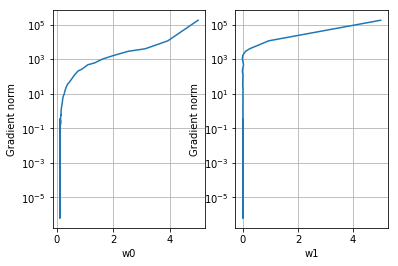

In [26]:
plt.subplot(1,2,1)
plt.semilogy(df7['w0'], df7['Gradient norm'])
plt.xlabel('w0')
plt.ylabel('Gradient norm')
plt.grid();
plt.subplot(1,2,2)
plt.semilogy(df7['w1'], df7['Gradient norm'])
plt.xlabel('w1')
plt.ylabel('Gradient norm')
plt.grid();

In [27]:
yEst7 = np.matmul(xTest, w7) + bEst

mse7 = 0.00025593624288219223


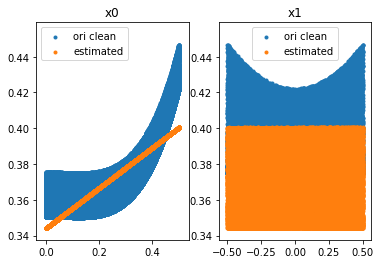

In [28]:
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst7, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst7, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse7 = metrics.mean_squared_error(yTest, yEst7)
print('mse7 =', mse7);

## SGD with powers

Adding powers of x to the stochastic gradient descent

In [29]:
# Batch size
Nbatch = 1000
# Initial coefficient (fixed and tuned manually for this trial)
w8 = np.ones(8)* 1.5 
# Gradient descent end threshold (on the gradient)
threshold = 1e-3
# Initial learning rate
learningRate = 0.01
# Initial batch
xBatch, yBatch, yBC = generateBatch(Nbatch)
xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
gradient = calcGradient(xBatch2, yBatch, w8)
gradientNorm = np.sum(gradient**2) 
print('w start =', w8, ', Gradient norm =', gradientNorm)
# Save the 
w8Learn = [np.concatenate((w8, [gradientNorm]))]
# Continue
while gradientNorm > threshold:
    w8 = w8 - learningRate * gradient
    xBatch, yBatch, yBC = generateBatch(Nbatch)
    xBatch2 = np.concatenate((xBatch, xBatch**2, xBatch**3, xBatch**4), axis = 1)
    gradient = calcGradient(xBatch2, yBatch, w8)
    gradientNorm = np.sum(gradient**2)
    #print('w =', w8, ', Gradient norm =', gradientNorm)
    w8Learn.append(np.concatenate((w8, [gradientNorm])))
    learningRate = learningRate * 0.999
print('w end =', w8, ', Gradient norm =', gradientNorm, ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('w0_1', 'w1_1', 'w0_2', 'w1_2', 'w0_3', 'w1_3', 'w0_4', 'w1_4', 'Gradient norm'))

w start = [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5] , Gradient norm = 24277.647391106657
w end = [ 0.01277147 -0.0105125  -0.18571655 -0.10633485  0.44169578  0.0742837
  0.93042283  0.96184823] , Gradient norm = 0.0009809202580851827 , num iteration = 1667


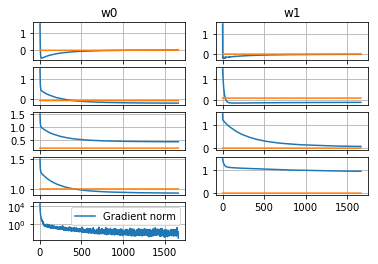

In [30]:
nIter = df8.shape[0]
r = range(nIter)
#
plt.subplot(5,2,1)
plt.plot(r, df8['w0_1'], r, np.ones((nIter))*fPoly[0,0])
plt.grid()
plt.title('w0');
plt.subplot(5,2,2)
plt.plot(r, df8['w1_1'], r, np.ones((nIter))*fPoly[0,1])
plt.grid()
plt.title('w1');
plt.subplot(5,2,3)
plt.plot(r, df8['w0_2'], r, np.ones((nIter))*fPoly[1,0])
plt.grid()
plt.subplot(5,2,4)
plt.plot(r, df8['w1_2'], r, np.ones((nIter))*fPoly[1,1])
plt.grid()
plt.subplot(5,2,5)
plt.plot(r, df8['w0_3'], r, np.ones((nIter))*fPoly[2,0])
plt.grid()
plt.subplot(5,2,6)
plt.plot(r, df8['w1_3'], r, np.ones((nIter))*fPoly[2,1])
plt.grid()
plt.subplot(5,2,7)
plt.plot(r, df8['w0_4'], r, np.ones((nIter))*fPoly[3,0])
plt.grid()
plt.subplot(5,2,8)
plt.plot(r, df8['w1_4'], r, np.ones((nIter))*fPoly[3,1])
plt.grid()
plt.subplot(5,2,9)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.legend();

Convergence is not correct on $x_1^4$

In [31]:
yEst8 = np.matmul(xTest2, w8) + bEst

mse8 = 0.0002640554938257977


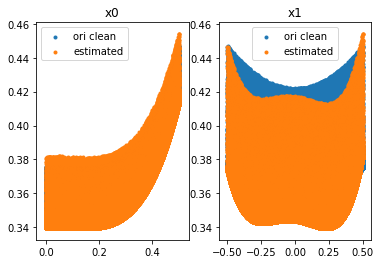

In [32]:
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst8, marker='.')
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst8, marker='.')
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse8 = metrics.mean_squared_error(yTest, yEst8)
print('mse8 =', mse8);

The quadratic terms are not improving the MSE and are making the descent harder to tune